<a href="https://colab.research.google.com/github/Ajay-user/ML-DL-RL-repo/blob/master/Regression/Interpreting_the_coefficients_of_linear_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

In linear models, the target value is modeled as a linear combination of the features.

The coefficients of linear models represent the relationship between the given feature,`X(i)`  and the target, `y` , assuming that all the other features remain constant (conditional dependence). 

In [58]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load the data

In [59]:
from sklearn.datasets import fetch_openml

survey = fetch_openml(data_id=534, as_frame=True)

In [60]:
X = survey.data
y = survey.target

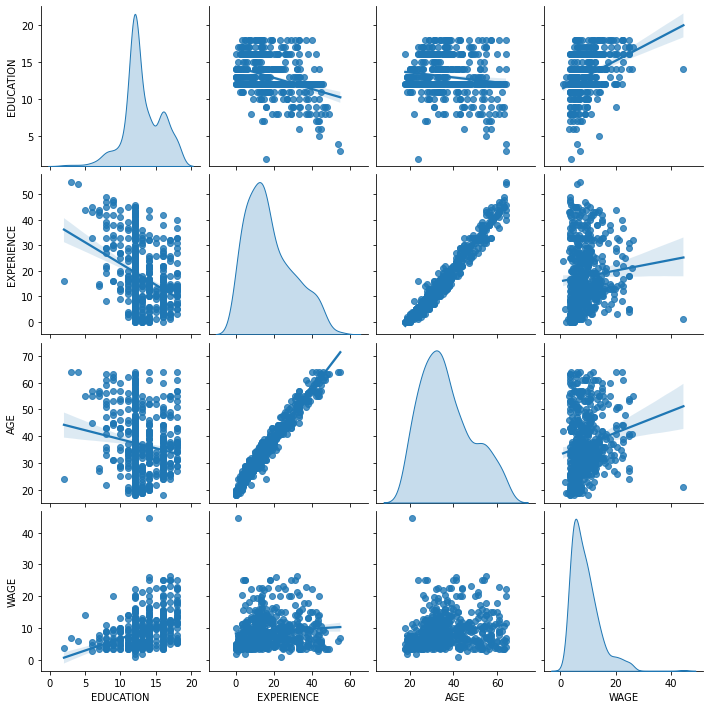

In [61]:
df = X.copy()
df[y.name]=y
sns.pairplot(df, kind='reg', diag_kind='kde');

In [62]:
df.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR,WAGE
0,8.0,no,female,21.0,not_member,35.0,Hispanic,Other,Manufacturing,Married,5.10
1,9.0,no,female,42.0,not_member,57.0,White,Other,Manufacturing,Married,4.95
2,12.0,no,male,1.0,not_member,19.0,White,Other,Manufacturing,Unmarried,6.67
3,12.0,no,male,4.0,not_member,22.0,White,Other,Other,Unmarried,4.00
4,12.0,no,male,17.0,not_member,35.0,White,Other,Other,Married,7.50


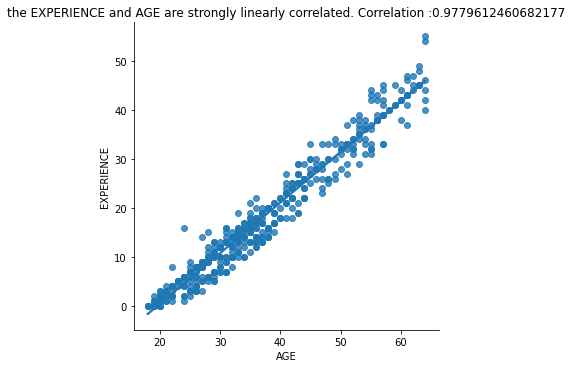

In [63]:
from matplotlib.offsetbox import AnchoredText

sns.lmplot(x='AGE', y='EXPERIENCE', data=df);
rel =  'Correlation :'+str(df['AGE'].corr(df['EXPERIENCE']))
plt.title('the EXPERIENCE and AGE are strongly linearly correlated. '+rel);

In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## The machine-learning pipeline

* one-hot encode (i.e., generate a column by category) the categorical columns, only for non-binary categorical variables;

* as a first approach lets keep numerical values as they are, later normalize them to see the effect 


In [65]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import Ridge

from sklearn.compose import TransformedTargetRegressor

In [66]:
categorical_columns = ["RACE", "OCCUPATION", "SECTOR", "MARR", "UNION", "SEX", "SOUTH"]
numerical_columns = ["EDUCATION", "EXPERIENCE", "AGE"]

prep = ColumnTransformer(transformers=[
              ('categorical', OneHotEncoder(drop='if_binary'), categorical_columns)               
], remainder='passthrough',  verbose_feature_names_out=False)


model = TransformedTargetRegressor(regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10)


pipe = Pipeline(steps=[('preprocess', prep), ('modeling',model)])

In [67]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH'])],
                                   verbose_feature_names_out=False)),
                ('modeling',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=1e-10)))])

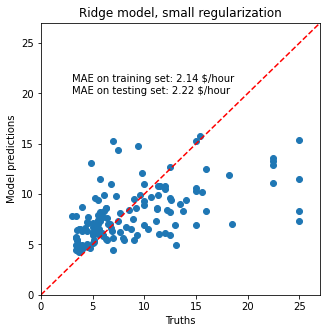

In [68]:
from sklearn.metrics import median_absolute_error

def evaluate_model(model):


  y_pred = model.predict(X_train)
  mae = median_absolute_error(y_train, y_pred)
  string_score = f"MAE on training set: {mae:.2f} $/hour"

  y_pred = model.predict(X_test)
  mae = median_absolute_error(y_test, y_pred)
  string_score += f"\nMAE on testing set: {mae:.2f} $/hour"

  fig, ax = plt.subplots(figsize=(5, 5))
  plt.scatter(y_test, y_pred)
  ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
  plt.text(3, 20, string_score)
  plt.title("Ridge model, small regularization")
  plt.ylabel("Model predictions")
  plt.xlabel("Truths")
  plt.xlim([0, 27])
  _ = plt.ylim([0, 27])
    


evaluate_model(pipe)

## Interpreting coefficients

In [69]:
feature_names = pipe['preprocess'].get_feature_names_out()

coef_df = pd.DataFrame(data=pipe['modeling'].regressor_.coef_, index=feature_names, columns=['coefficients'])

coef_df

,coefficients
RACE_Hispanic,-0.013555
RACE_Other,-0.009111
RACE_White,0.022558
OCCUPATION_Clerical,0.000056
OCCUPATION_Management,0.090539
OCCUPATION_Other,-0.025091
OCCUPATION_Professional,0.071975
OCCUPATION_Sales,-0.046625
OCCUPATION_Service,-0.091042
SECTOR_Construction,-0.000177


The most important factor in determining WAGE appears to be the variable UNION, even if our intuition might tell us that variables like EXPERIENCE should have more impact.

Looking at the coefficient plot to gauge feature importance can be misleading as some of them vary on a small scale, while others, like AGE, varies a lot more,

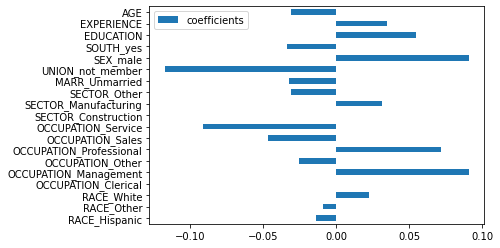

In [70]:
# lets plot the coef
coef_df.plot(kind='barh');

We cannot compare the magnitude of different coefficients since the features have different natural scales, and hence value ranges, because of their different unit of measure. 

For eg: AGE & EXPERIENCE are measured in years -- how about SEX & UNION , they are categorical. 

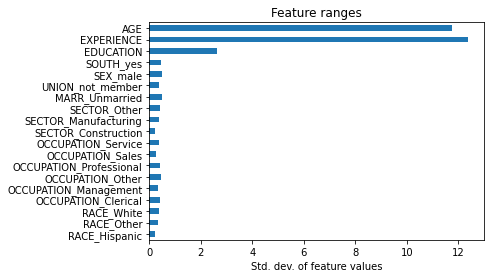

In [71]:
# compare the standard deviations of different features.

X_train_preprocessed = pd.DataFrame(data=pipe['preprocess'].transform(X_train), columns=feature_names)

X_train_preprocessed.std(axis=0).plot(kind='barh');
plt.title("Feature ranges")
plt.xlabel("Std. dev. of feature values");


Multiplying the coefficients by the standard deviation of the related feature would reduce all the coefficients to the same unit of measure. 

In this way, we emphasize that the greater the variance of a feature, the larger the weight of the corresponding coefficient on the output, all else being equal.

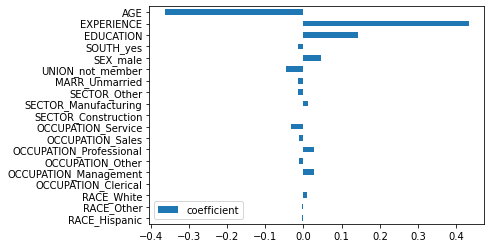

In [72]:
data=pipe['modeling'].regressor_.coef_*pipe['preprocess'].transform(X_train).std(axis=0)

coef_df = pd.DataFrame(data, index=feature_names, columns=['coefficient'])
coef_df.plot(kind='barh');

Why does the plot above suggest that an increase in age leads to a decrease in wage? Why the initial pairplot is telling the opposite?

The plot above tells us about dependencies between a specific feature and the target when all other features remain constant, i.e., conditional dependencies. 

An increase of the AGE will induce a decrease of the WAGE when all other features remain constant. On the contrary, an increase of the EXPERIENCE will induce an increase of the WAGE when all other features remain constant. Also, AGE, EXPERIENCE and EDUCATION are the three variables that most influence the model.

## Checking the variability of the coefficients

If coefficients vary significantly when changing the input dataset their robustness is not guaranteed, and they should probably be interpreted with caution.

In [73]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

kfold = RepeatedKFold(n_repeats=5)
cv_score = cross_validate(pipe, X, y, cv=kfold, return_estimator=True)

In [74]:
coefs = pd.DataFrame(
    [
        est['modeling'].regressor_.coef_ * est['preprocess'].transform(X.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_score['estimator'], kfold.split(X, y))
    ],
    columns=feature_names,
)

Text(0.5, 1.0, 'Coefficient importance and its variability')

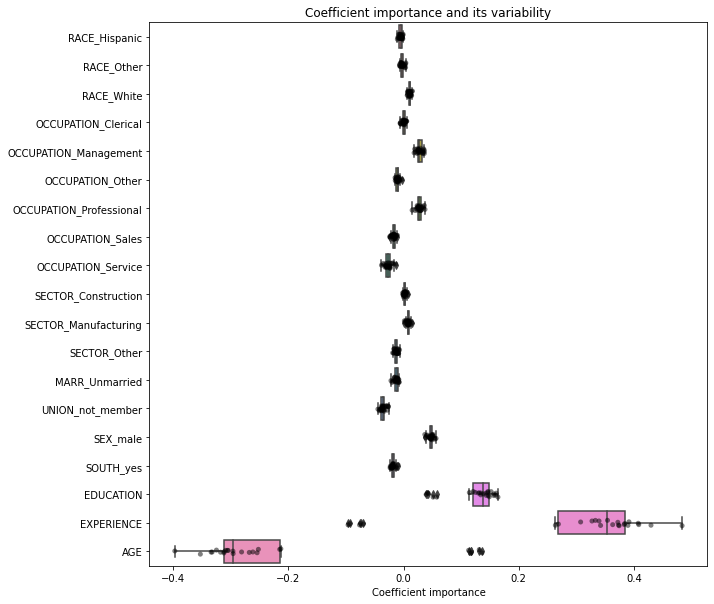

In [75]:
plt.figure(figsize=(10,10))
sns.stripplot(data=coefs, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs, orient='h')
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")

## The problem of correlated variable
The AGE and EXPERIENCE coefficients are affected by strong variability which might be due to the collinearity between the two features: as AGE and EXPERIENCE vary together in the data, their effect is difficult to tease apart.

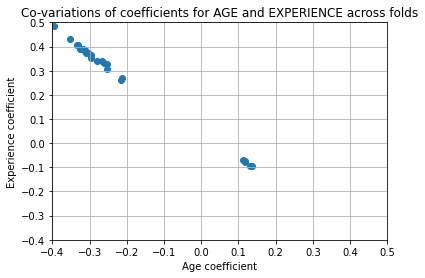

In [76]:
plt.xlabel("Age coefficient")
plt.ylabel("Experience coefficient")
plt.grid(True)
plt.xlim(-0.4, 0.5)
plt.ylim(-0.4, 0.5)
plt.scatter(coefs["AGE"], coefs["EXPERIENCE"])
_ = plt.title("Co-variations of coefficients for AGE and EXPERIENCE across folds")

when the EXPERIENCE coefficient is positive the AGE one is negative and vice-versa.

Let's remove one of the 2 features and check what is the impact on the model stability.

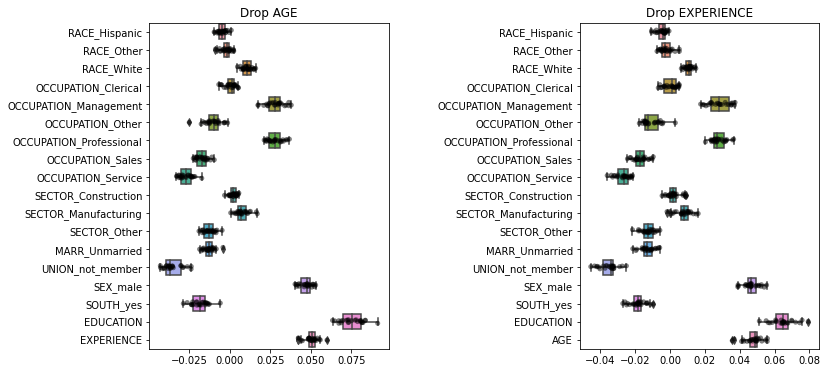

In [77]:
kfold = RepeatedKFold(n_repeats=5)

cv_1 = cross_validate(pipe, X.drop('AGE',axis=1), y, cv=kfold, return_estimator=True)
cv_2 = cross_validate(pipe, X.drop('EXPERIENCE',axis=1), y, cv=kfold, return_estimator=True)

coefs_1 = pd.DataFrame(
    [
        est['modeling'].regressor_.coef_ * est['preprocess'].transform(X.drop('AGE',axis=1).iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_1['estimator'], kfold.split(X.drop('AGE',axis=1), y))
    ],
    columns=[i for i in feature_names if i !='AGE'],
)

coefs_2 = pd.DataFrame(
    [
        est['modeling'].regressor_.coef_ * est['preprocess'].transform(X.drop('EXPERIENCE',axis=1).iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_2['estimator'], kfold.split(X.drop('EXPERIENCE',axis=1), y))
    ],

    columns=[i for i in feature_names if i !='EXPERIENCE']
)


plt.figure(figsize=(12,6))
plt.subplot(121)
sns.stripplot(data=coefs_1, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs_1, orient='h')
plt.title('Drop AGE')
plt.subplot(122)
sns.stripplot(data=coefs_2, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs_2, orient='h')
plt.title('Drop EXPERIENCE')
plt.subplots_adjust(wspace=0.8)

## Preprocessing numerical variables

In [78]:
from pandas.core import apply
from sklearn.preprocessing import StandardScaler

prep = ColumnTransformer(transformers=[
                                       ('cat', OneHotEncoder(drop='if_binary'), categorical_columns),
                                       ('num', StandardScaler(), numerical_columns)
])

model = TransformedTargetRegressor(regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10)

pipe = Pipeline(steps=[('preprocess',prep),('modeling',model)])

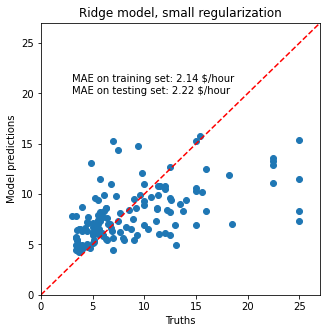

In [79]:
pipe.fit(X_train, y_train)

evaluate_model(pipe)

For the coefficient analysis, scaling is not needed this time because it was performed during the preprocessing step.

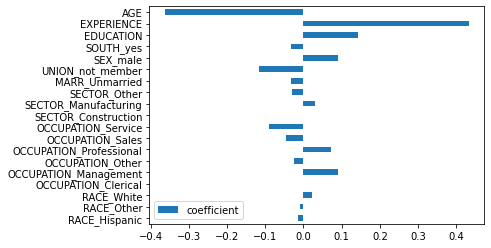

In [80]:
coef_df = pd.DataFrame(data=pipe['modeling'].regressor_.coef_, columns=['coefficient'], index=feature_names)
coef_df.plot(kind='barh');

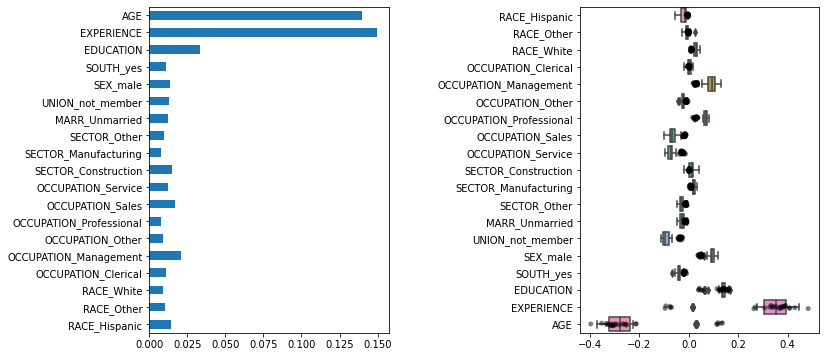

In [81]:
#  inspect the coefficients across several cross-validation folds. 
kfold = RepeatedKFold(n_repeats=5)
cv_result = cross_validate(pipe, X, y, cv=kfold, return_estimator=True)
coef = pd.DataFrame(data = [est['modeling'].regressor_.coef_ for est in cv_result['estimator']] , columns=feature_names)

plt.figure(figsize=(12,6))
plt.subplot(121)
coef.std(axis=0).plot(kind='barh')
plt.subplot(122)
sns.stripplot(data=coefs, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coef, orient='h');
plt.subplots_adjust(wspace=0.8);

## Linear models with regularization

The ridge regression is more often used with non-negligible regularization.



Above, we limited this regularization to a very little amount.

Regularization improves the conditioning of the problem and reduces the variance of the estimates.

RidgeCV applies cross validation in order to determine which value of the regularization parameter (alpha) is best suited for prediction.

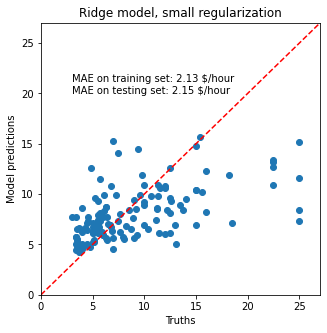

In [82]:
from sklearn.linear_model import RidgeCV

aplhas = np.logspace(-10,10,20)
model = TransformedTargetRegressor(regressor=RidgeCV(alphas=aplhas), func=np.log10, inverse_func=sp.special.exp10)
pipe = Pipeline(steps=[('preprocess',prep),('modeling',model)])

pipe.fit(X_train,y_train)

evaluate_model(pipe)

In [83]:
print('Best aplha found', pipe['modeling'].regressor_.alpha_)

Best aplha found 3.359818286283774


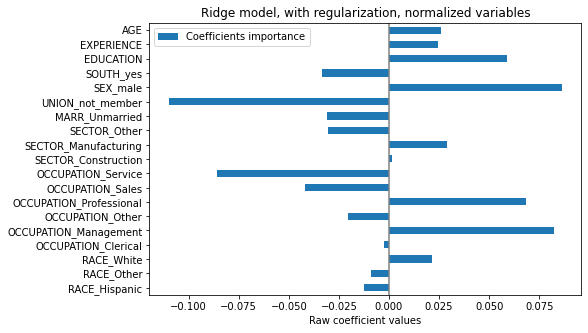

In [84]:
coefs = pd.DataFrame(
    pipe['modeling'].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot.barh(figsize=(10,5))
plt.title("Ridge model, with regularization, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

The coefficients are significantly different. AGE and EXPERIENCE coefficients are both positive but they now have less influence on the prediction.

The regularization reduces the influence of correlated variables on the model 

On the other hand, the weights obtained with regularization are more stable

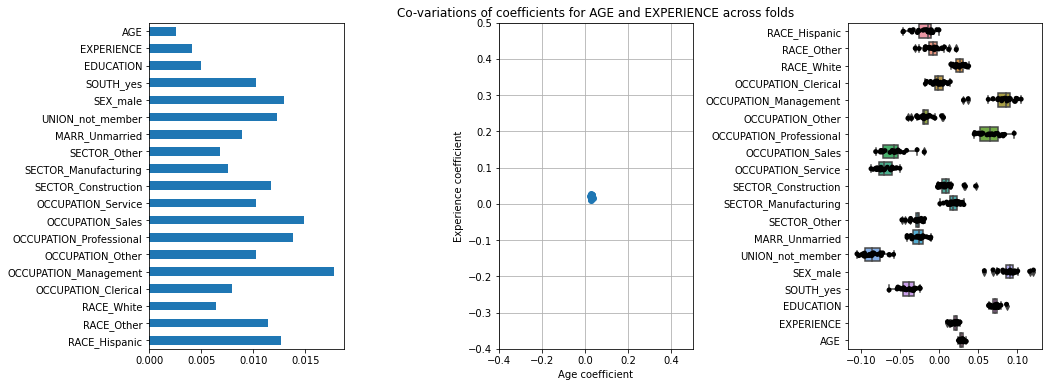

In [97]:
#  inspect the coefficients across several cross-validation folds. 
kfold = RepeatedKFold(n_repeats=5)
cv_result = cross_validate(pipe, X, y, cv=kfold, return_estimator=True)
coef = pd.DataFrame(data = [est['modeling'].regressor_.coef_ for est in cv_result['estimator']] , columns=feature_names)

plt.figure(figsize=(16,6))
plt.subplot(131)
coef.std(axis=0).plot(kind='barh')

plt.subplot(132)
plt.xlabel("Age coefficient")
plt.ylabel("Experience coefficient")
plt.grid(True)
plt.xlim(-0.4, 0.5)
plt.ylim(-0.4, 0.5)
plt.scatter(coef["AGE"], coef["EXPERIENCE"])
_ = plt.title("Co-variations of coefficients for AGE and EXPERIENCE across folds")

plt.subplot(133)
sns.stripplot(data=coef, orient='h', color='k')
sns.boxplot(data=coef, orient='h')
plt.subplots_adjust(wspace=0.8);

## Linear models with sparse coefficients

Another possibility to take into account correlated variables in the dataset, is to estimate sparse coefficients. In some way we already did it manually when we dropped the AGE column in a previous ridge estimation.

Lasso models  estimates sparse coefficients.

LassoCV applies cross validation in order to determine which value of the regularization parameter (alpha) is best suited for the model estimation.

In [106]:
from sklearn.linear_model import LassoCV

alphas = np.logspace(-10,10,20)
model = TransformedTargetRegressor(regressor=LassoCV(alphas=alphas, max_iter=100000), func=np.log10, inverse_func=sp.special.exp10)

pipe = Pipeline(steps=[('preprocess',prep),('modeling',model)])
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH']),
                                                 ('num', StandardScaler(),
                                                  ['EDUCATION', 'EXPERIENCE',
                                                   'AGE'])])),
                ('modeling',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=LassoCV(alphas=array([1.00000000e-10, 1.12883789e-09, 1.27427499e-08, 1.43844989e-07,
       1.62377674e-06, 1.83298071e-05, 2.06913808e-04, 2.33572147e-03,
       2.6366

In [107]:
pipe['modeling'].regressor_.alpha_

0.002335721469090121

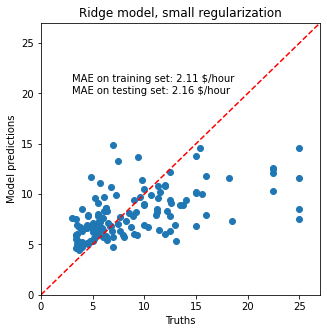

In [108]:
evaluate_model(pipe)

For our dataset, again the model is not very predictive.

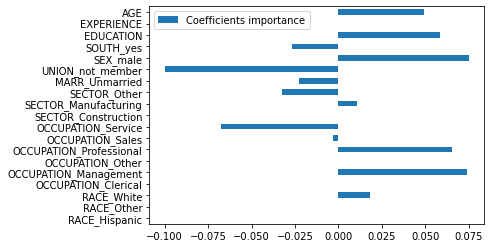

In [110]:
coefs = pd.DataFrame(
    pipe['modeling'].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot(kind="barh");

A Lasso model identifies the correlation between AGE and EXPERIENCE and suppresses one of them for the sake of the prediction.

It is important to keep in mind that the coefficients that have been dropped may still be related to the outcome by themselves: the model chose to suppress them because they bring little or no additional information on top of the other features. 

In [117]:
# variability of the coefficients across folds.

kfold = RepeatedKFold(n_repeats=5)
cv_result = cross_validate(pipe, X, y, cv=kfold, return_estimator=True)
coefs = pd.DataFrame(data=[est['modeling'].regressor_.coef_ for est in cv_result['estimator']] ,columns=feature_names)

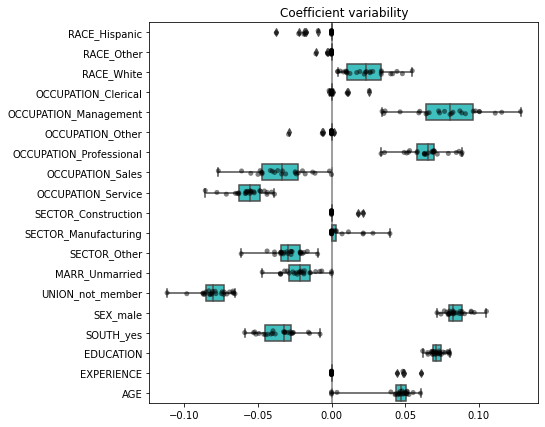

In [120]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=100)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability")
plt.subplots_adjust(left=0.3)

## Learnings

* Coefficients must be scaled to the same unit of measure to retrieve feature importance. Scaling them with the standard-deviation of the feature is a useful proxy.

* Coefficients in multivariate linear models represent the dependency between a given feature and the target, conditional on the other features.

* Correlated features induce instabilities in the coefficients of linear models and their effects cannot be well teased apart.

* Different linear models respond differently to feature correlation and coefficients could significantly vary from one another.

* Inspecting coefficients across the folds of a cross-validation loop gives an idea of their stability.